In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
import pybert as pb

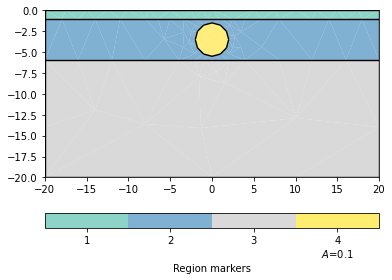

In [2]:
world = mt.createWorld(start=[-20, 0], end=[20, -20], layers=[-1, -6], worldMarker=1)
# Create some heterogeneous circle and merge with world
block = mt.createCircle(pos=[0, -3.5], radius=2, marker=4, boundaryMarker=10, area=0.1)
geom = mt.mergePLC([world, block])
pg.show(geom);

In [3]:
# place electrodes in the mesh and refine them
xEl = np.linspace(-10, 10, 21)
[geom.createNode((x, 0, 0), -99) for x in xEl]
[geom.createNode((x, -0.1, 0)) for x in xEl]
mesh = mt.createMesh(geom)
print(mesh)

Mesh: Nodes: 672 Cells: 1179 Boundaries: 1850


In [4]:
data = ert.createData(elecs=xEl, schemeName='dd')
data["k"] = ert.geometricFactors(data)
print(data)

Data: Electrodes: 21 data: 171


In [5]:
rhoMap = np.array([0, 100, 300, 30, 1000], dtype=float)
rhoVec = rhoMap[mesh.cellMarkers()]
print(np.unique(rhoVec))

[  30.  100.  300. 1000.]


20/12/22 - 10:26:19 - pyGIMLi - INFO - Found 1 regions.
20/12/22 - 10:26:19 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/12/22 - 10:26:19 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.


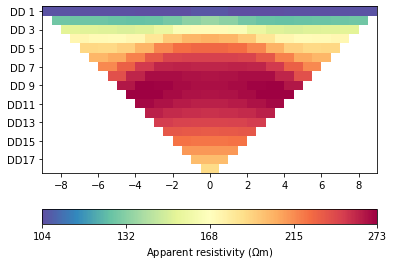

In [6]:
mesh0 = pg.Mesh(mesh)
mesh0.setCellMarkers(pg.Vector(mesh0.cellCount()))
fopDC = ert.ERTModelling()
fopDC.setMesh(mesh0)
fopDC.setData(data)
print(fopDC)
data["rhoa"] = fopDC.response(rhoVec)
pg.show(data, "rhoa");

In [7]:
fopDC.createJacobian(rhoVec)

In [8]:
fopIP = pb.tdip.DCIPMModelling(fopDC, mesh, rhoVec)

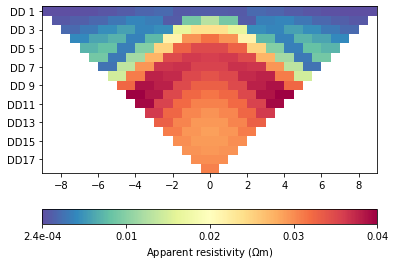

In [9]:
mMap = np.array([0, 0, 0, 0.1, 0.3])
mVec = mMap[mesh.cellMarkers()]
data["ma"] = fopIP.response(mVec)
pg.show(data, "ma", logScale=False);
data.save("simpleTDIP.dat", "a b m n rhoa k ma")

20/12/22 - 10:27:42 - pyGIMLi - INFO - Found 2 regions.
20/12/22 - 10:27:42 - pyGIMLi - INFO - Region with smallest marker (1) set to background
20/12/22 - 10:27:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/12/22 - 10:27:42 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.
20/12/22 - 10:27:42 - pyGIMLi - INFO - Use median(data values)=215.77206544147074
20/12/22 - 10:27:42 - pyGIMLi - INFO - Created startmodel from forward operator: 335 [215.77206544147074,...,215.77206544147074]


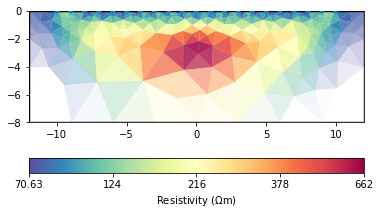

In [12]:
data["err"] = ert.estimateError(data, 0.03)
mgr = ert.Manager(data)
mgr.invert()
mgr.showResult();

In [ ]:
invIP = pg.Inversion()
fop = mgr.
invIP